<h1 align="center" style="background-color:DodgerBlue;">Prueba I - Machine Learning </h1>

### Contexto

En el problema corresponde a un trabajo de análisis de texto, en el que se debe extarer el sentimiento asociado a tweets de un dataset.

Para ello, se pide un modelo que sea capaz de predecir si un tweet es de sentimiento positivo o negativo, en base al dataset 'training_tweets.csv', el cual contiene una gran variedad de tweets con su respectivo sentimiento.
Para los casos de 'worry', 'sadness', 'hate', 'empty', 'boredom' y 'anger' se codificarán como negativos, 'happiness', 'love', 'surprice', 'fun', 'relief' y 'enthusiasm' como positivos y los que son 'neutral' se clasificarán aleatoriamente como positivo o negativo.

Este corresponde a un problema de clasificación binaria, ya que mediante la recodificación de los sentimientos el vector objetivo cuenta solo con 2 clases.

Para poder desarrollar lo solicitado, realizaremos multiples modelos de clasificación. Para ello, se implementan técnicas de minería de texto, procesamiento del lenguaje natural y aprendizaje automático para realizar una análisis de sentimientos en Twitter; utilizando para ello un conjunto de datos almacenados en un csv, el cual contiene dos columnas: Contenido y Sentimiento del mensaje. 

Cabe mencionar que la tarea de clasificación de sentimientos es difícil incluso para los humanos, en donde a veces no posible llegar a un acuerdo respecto a la polaridad del tweet. Además los textos en tweets están sujetos a errores de ortografía, abreviaciones, modismos y humor o sarcasmo. De forma similar al proceso seguido en; utilizamos los siguientes métodos para preprocesar los tweets: Corrección de errores: Para corregir algunos de los errores en el corpus se utilizó un diccionario en inglés, donde se introducen las correcciones ortográficas a los errores más comunes. Además se eliminaron los símbolos extras como “(”, “), ”, “!”, “.”, “:”, “;”, etc.

Se tokeniza el corpus, para generar cada palabra en un elemento único de una lista de datos, posteriormente se lematiza para corregir las singularidades.

Criterios de optimización y métricas de desempeño.
Para la evaluación de los resultados y determinar cual es el mejor modelo se realizará lo siguiente:

 - Analisis de los 5 modelos  y sus predicciones ocupando las siguientes metricas:

  - Evaluación de precision, recall, f1-score y accuracy.

In [1]:
# Aspectos computacionales
# Librerias clasicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import func as fx

# Informacion del sistema y datos perdidos
from sinfo import sinfo
import missingno as msngo

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import string

# Machine Learning
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

import pickle
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /Users/jorge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jorge/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jorge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jorge/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jorge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jorge/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jorge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jorge/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Aspectos computacionales, informacion del sistema y librerias a utilizar con versión
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
func        NA
matplotlib  3.5.3
missingno   0.5.1
nltk        3.7
numpy       1.21.5
pandas      1.4.4
seaborn     0.12.1
sinfo       0.3.4
sklearn     1.1.3
-----
IPython             7.31.1
jupyter_client      7.4.7
jupyter_core        4.11.2
jupyterlab          3.5.0
notebook            6.5.2
-----
Python 3.9.12 (main, Apr  5 2022, 01:53:17) [Clang 12.0.0 ]
macOS-10.16-x86_64-i386-64bit
8 logical CPU cores, i386
-----
Session information updated at 2022-12-15 23:59


In [3]:
help(fx.vectorize_sentiment)
help(fx.nlp_cleaning)
help(fx.clean_text)

Help on function vectorize_sentiment in module func:

vectorize_sentiment(df, sentimiento='sentiment', objetivo='content', stop_words_='english', plot=False)
    Devuelve una matriz dispersa para analisis de texto.

Help on function nlp_cleaning in module func:

nlp_cleaning(df)
    Devuelve un dataset con el preprocesamiento listo.

Help on function clean_text in module func:

clean_text(df, col_name, new_col_name)
    Funcion que limpia el dataset de caracteres especiales como A-Za-z0-9 etc.



La estrategia de división de muestras será: content como nuestro X y Sentiment como nuestro vector Objetivo Y.

El preprocesamiento será bajo el siguiente orden:
    - Llamar a la función auxiliar clean_text, la cual nos permite limpiar la columna content(corpus) y dejar en una nueva columna content_clean el corpus limpio(sin caracteres especiales).
    - Posteriormente se llama a la función nlp_cleaning, la cual realiza los procesos de reemplazo de StopWords, Tokenización,  Lematatización y posterior unión de los tokens lematizados en la columna content_clean.

Los cinco modelos propuestos de forma preeliminar con hiperparametros tentativos para revisar sus metricas, y posteriormente realizar un trabajo de ajuste de grilla son:

 - MultinomialNB() params = {'alpha': np.linspace(0,20,20)[1:],'class_prior':[None,2,5,10]}
 - RandomForestClassifier() params = {'max_depth':[None, 10, 50, 70], 'n_estimators':[50, 100, 150, 200, 250, 500]}
  - DecisionTreeClassifier() params = {'max_depth':[None, 10, 50, 70], 'min_samples_split':[50, 100, 150, 200, 250, 500], 'ccp_alpha':[10, 20, 30, 40, 50]}
 - LinearSVC() params = {'tol' : [1e-4, 1e-5, 1e-6], 'loss' : ['squared_hinge', 'hinge'], 'max_iter':[50, 100, 150]}
 - LogisticRegression() params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty': ['l1', 'l2']}

In [4]:
df = pd.read_csv('training_tweets.csv').drop(columns = 'Unnamed: 0', axis = 1)
df.sample(5, random_state = 15820)

,content,sentiment
17932,@patrickmanning Yes PM PM you are right,happiness
8768,@Jae878 aha thanks Jae,happiness
14419,"This is my favourite shirt, because its true. ...",neutral
18237,@taylorswift13 ....... i'm wondering if you're...,worry
15206,"@taylor_d No, it's not...",neutral


El vector objetivo sentiment de forma preeliminar presenta la siguiente distribución. Mas abajo se puede apreciar de forma grafica, las palabras con mayor presencia dentro de cada sentimiento.

In [5]:
df['sentiment'].value_counts('%')*100

neutral       21.503333
worry         21.123333
happiness     13.173333
sadness       12.896667
love           9.693333
surprise       5.396667
fun            4.436667
relief         3.860000
hate           3.250000
empty          2.056667
enthusiasm     1.863333
boredom        0.450000
anger          0.296667
Name: sentiment, dtype: float64

<AxesSubplot:title={'center':'Frecuencia de sentimientos'}, xlabel='count', ylabel='sentiment'>

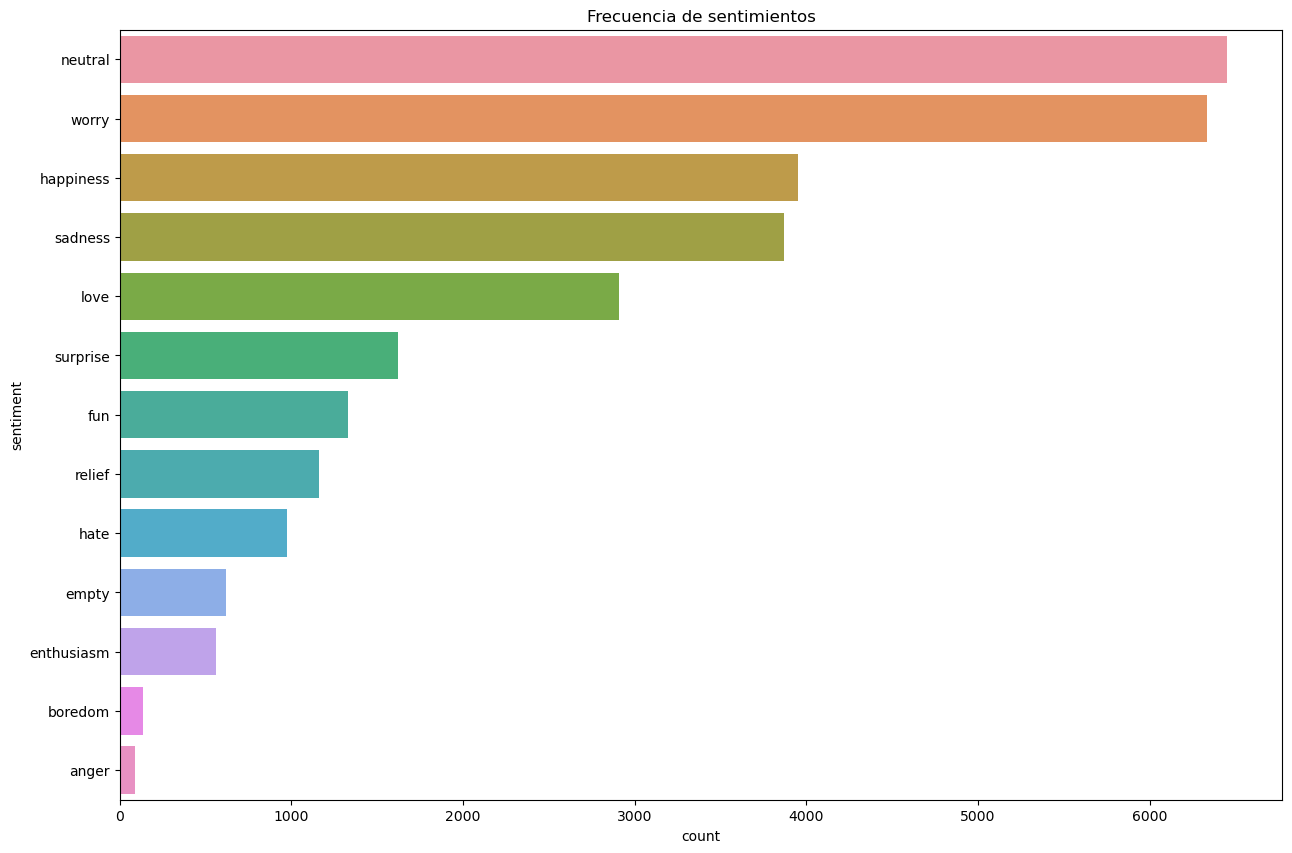

In [6]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["xtick.labelsize"] = 10
plt.title('Frecuencia de sentimientos')
sns.countplot(y= 'sentiment', order = df['sentiment'].value_counts().index, data = df)

In [7]:
print(f'''El dataset contiene {df.shape[0]} filas y {df.shape[1]} columnas''')

El dataset contiene 30000 filas y 2 columnas


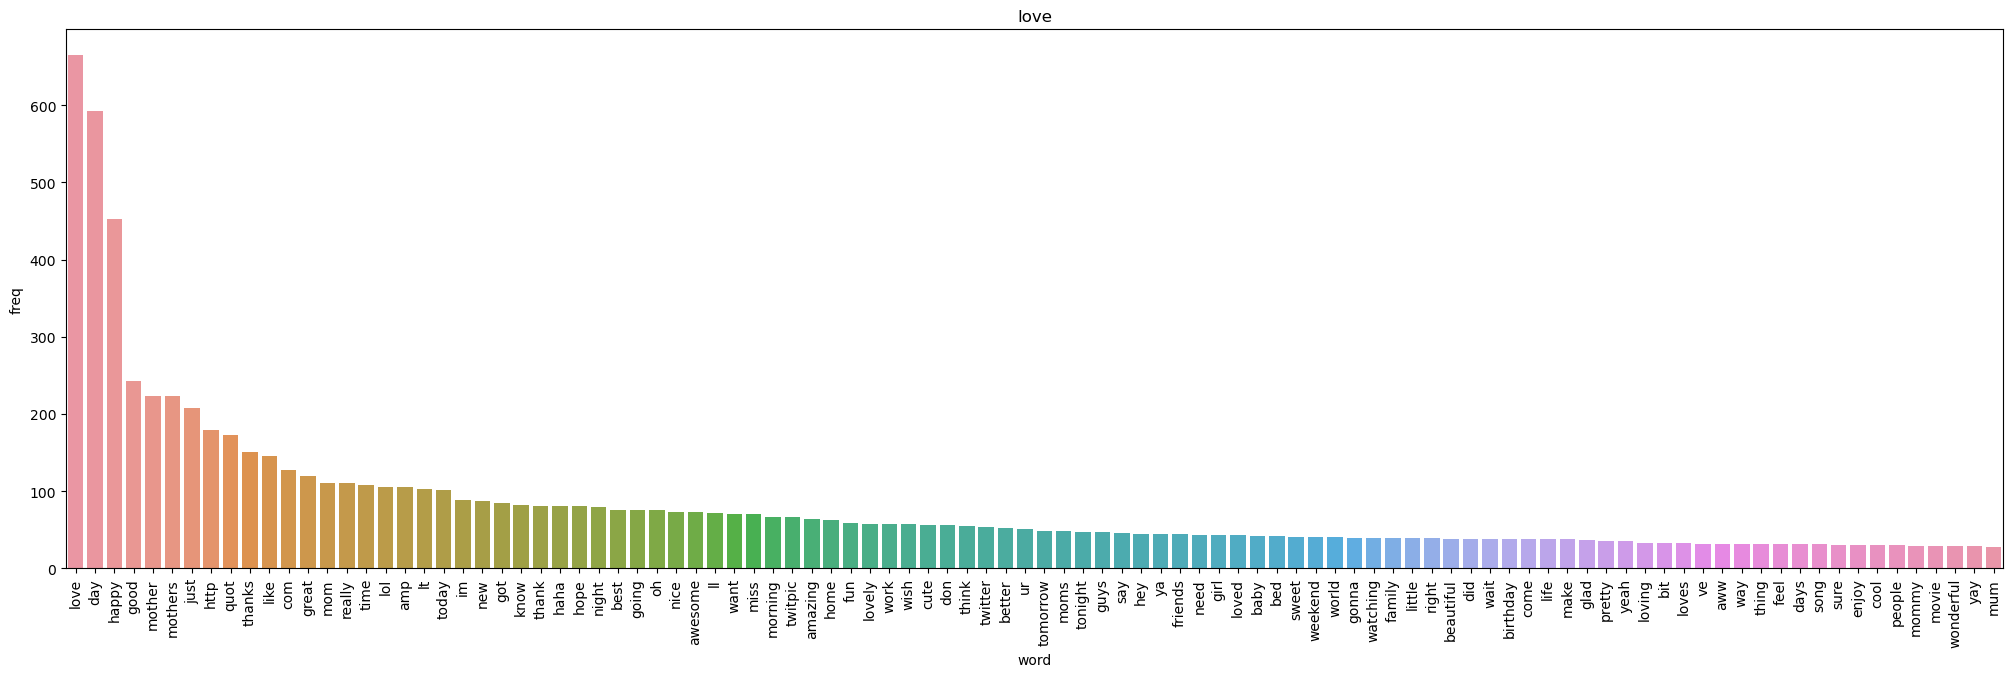

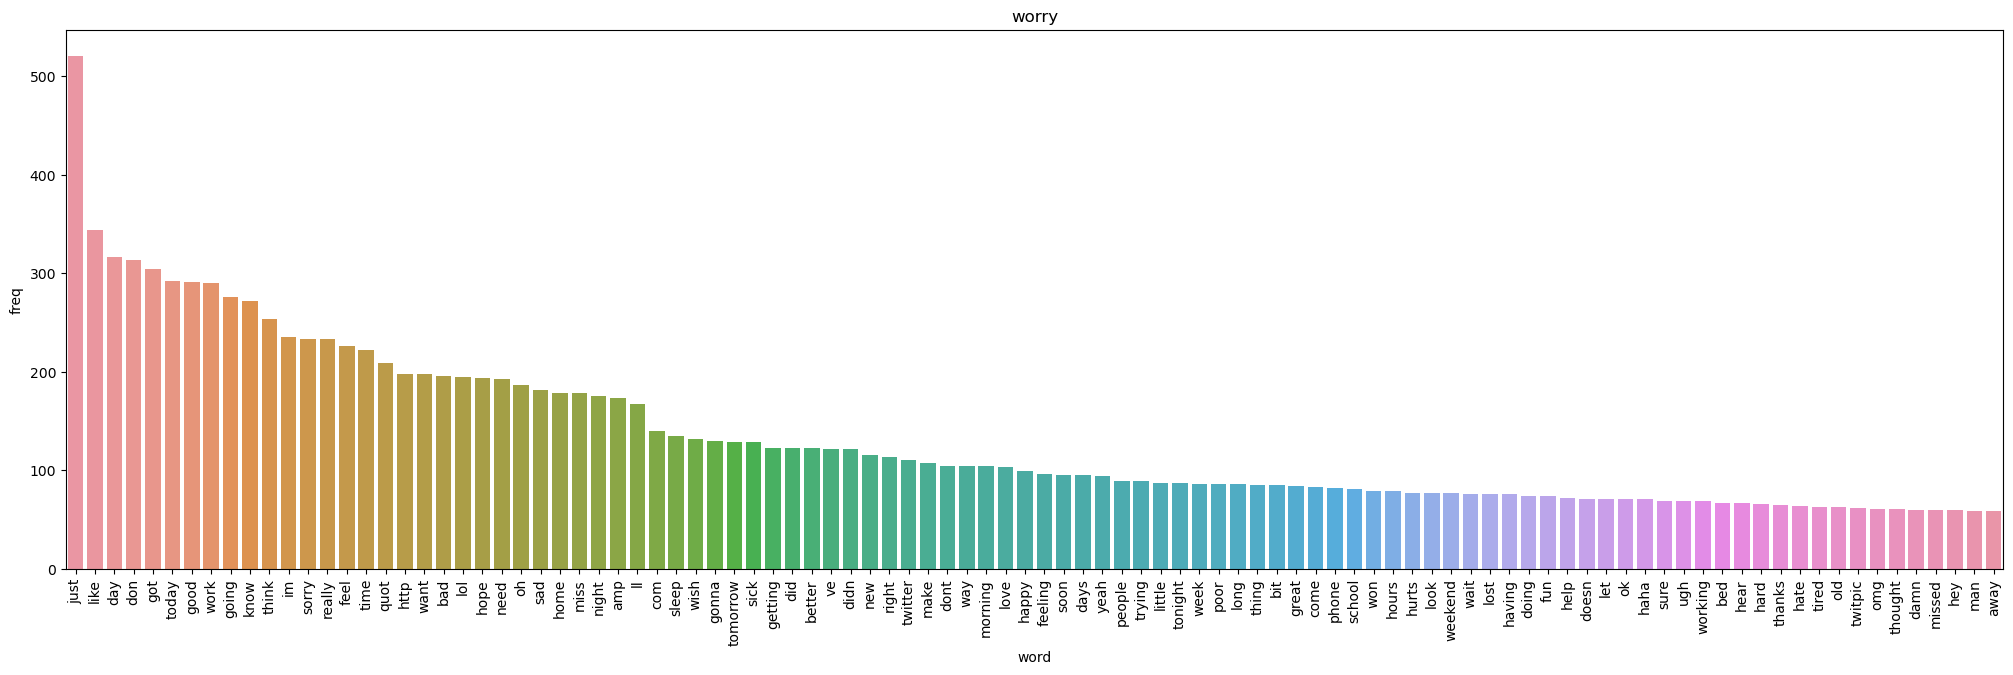

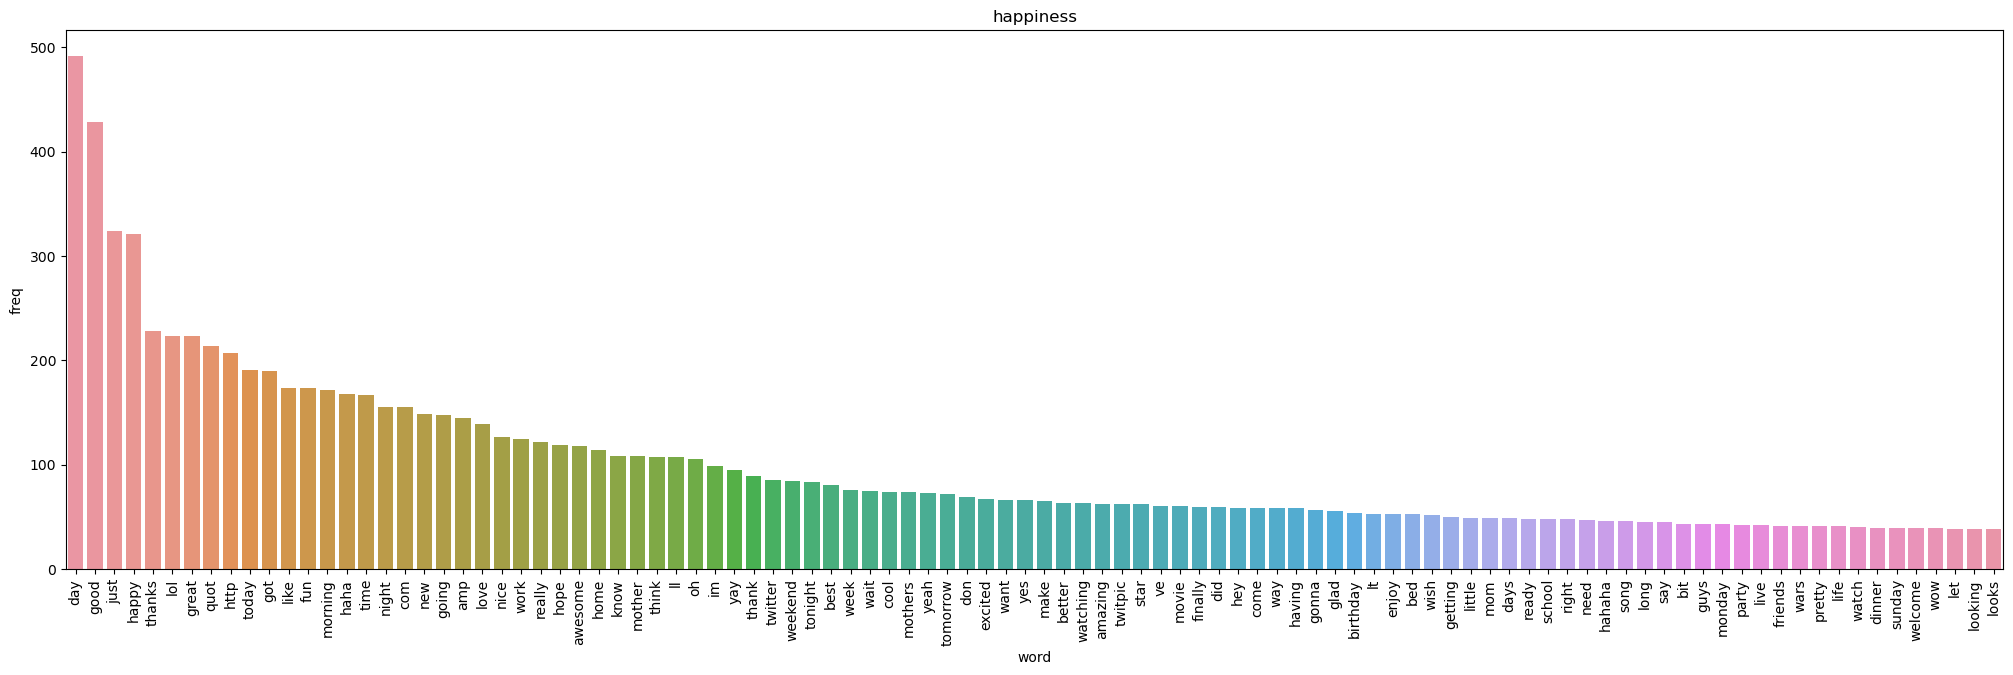

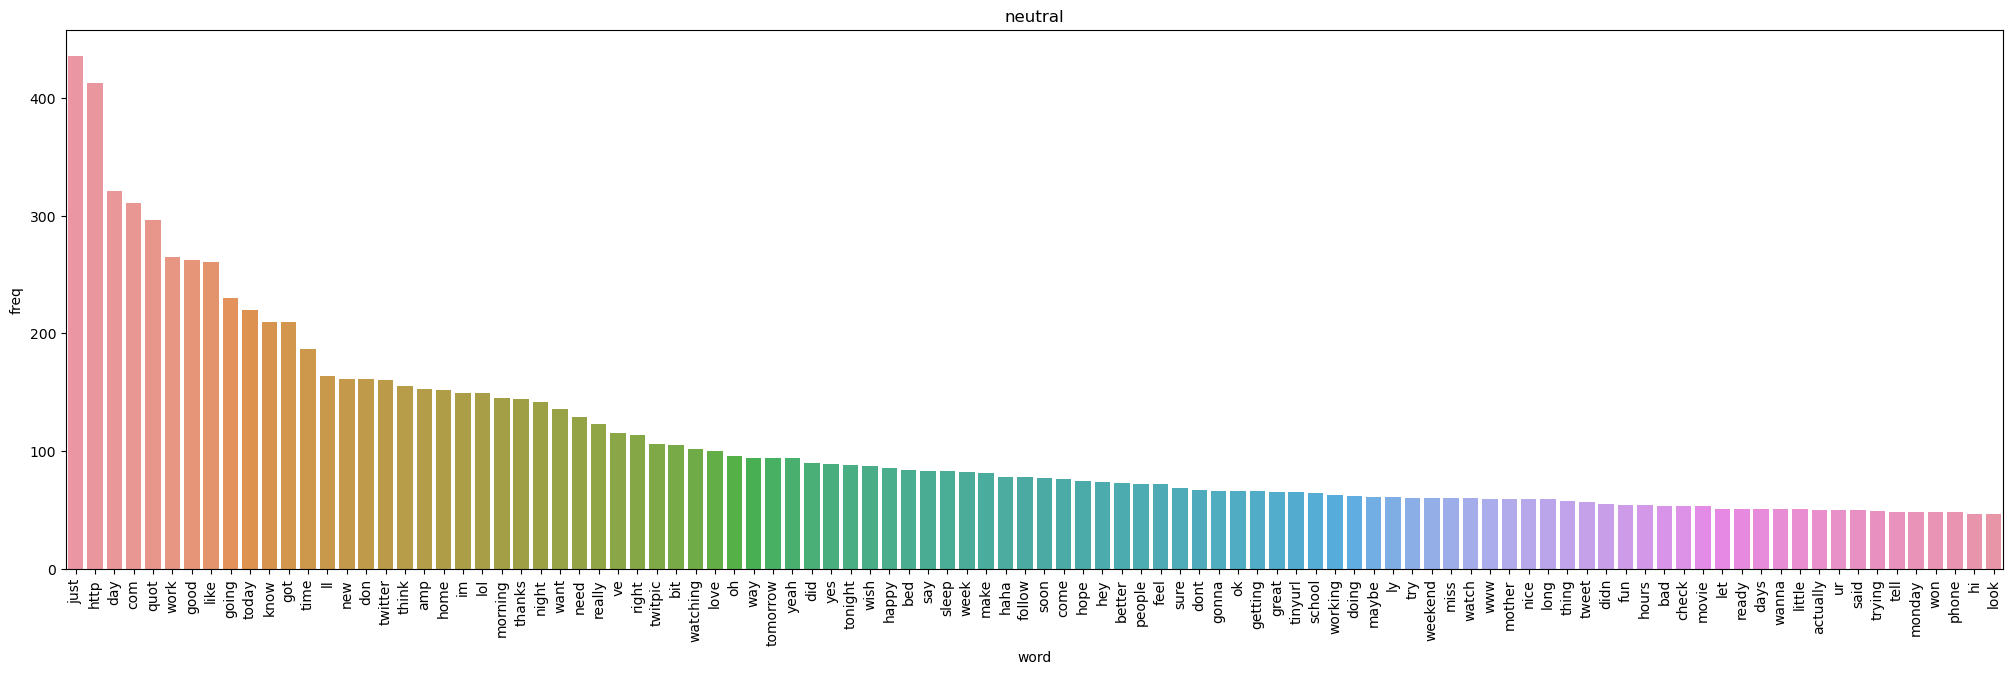

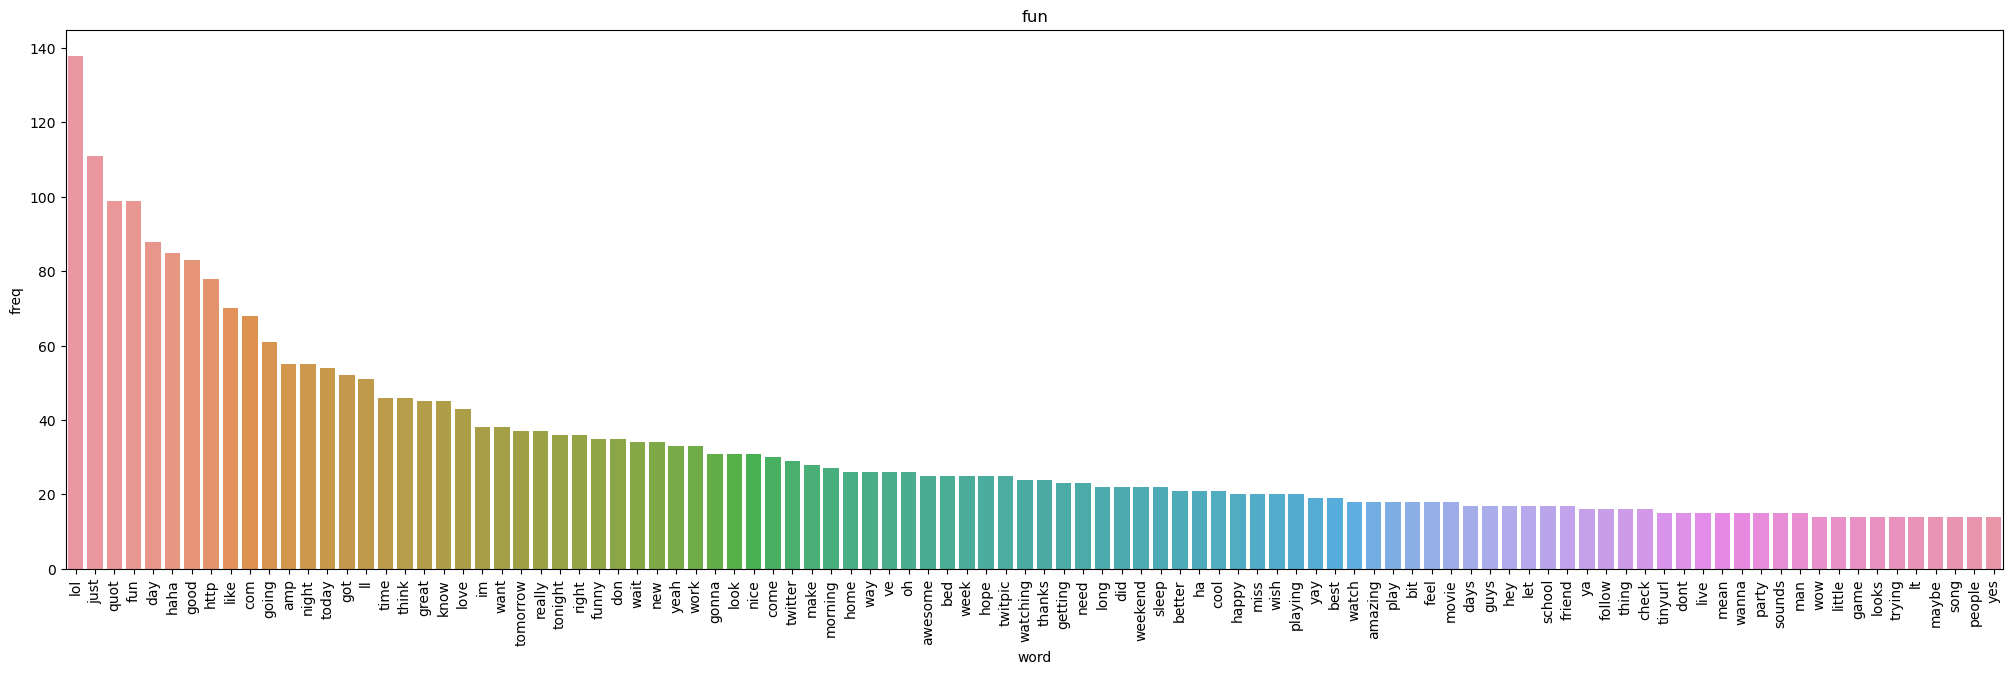

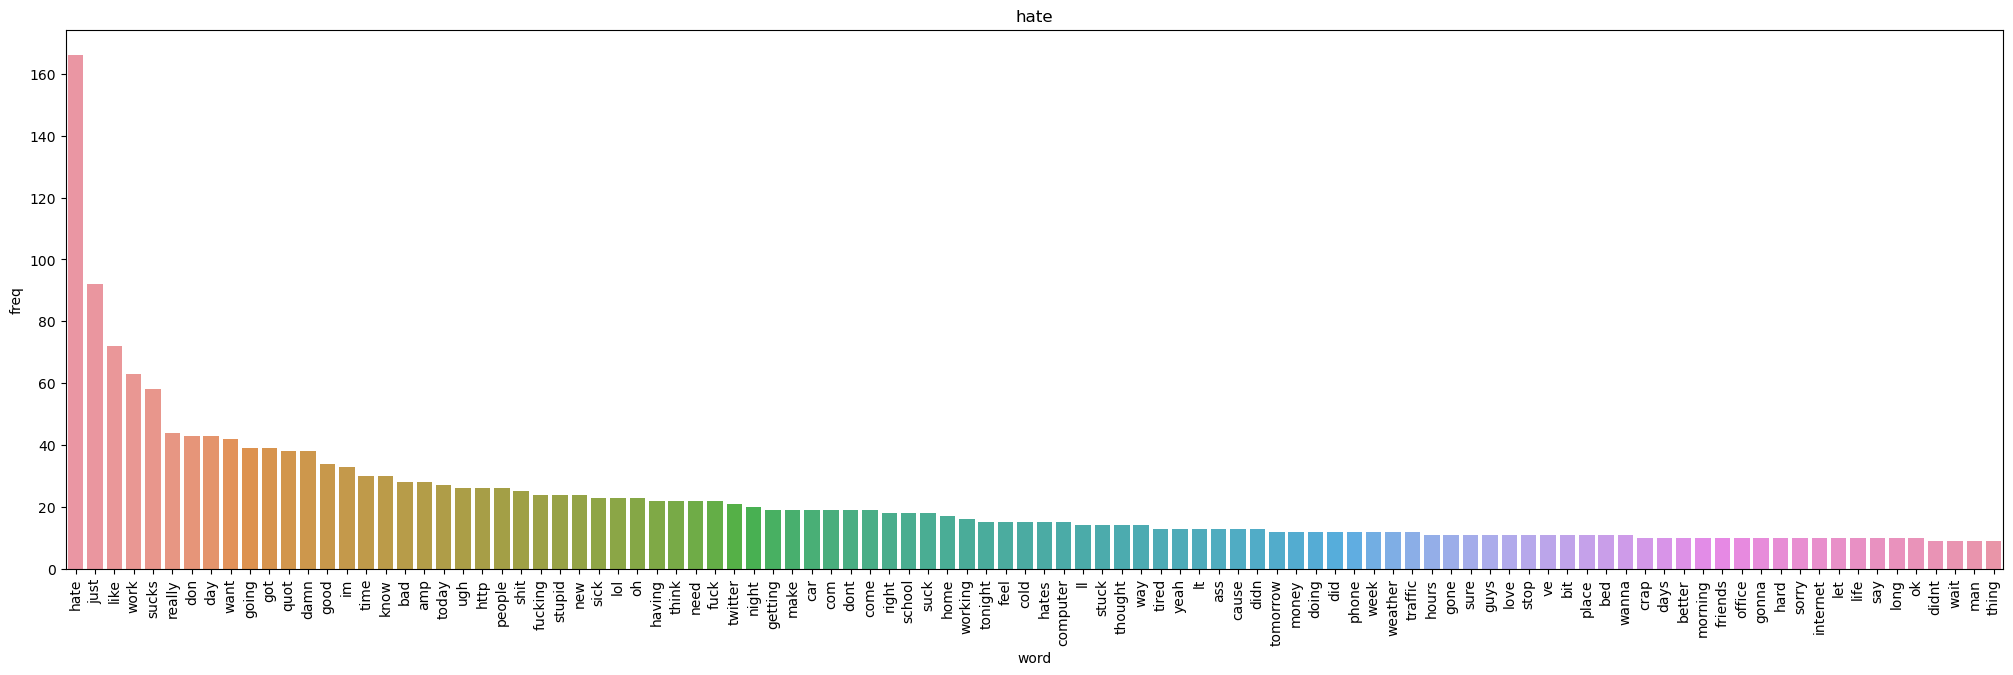

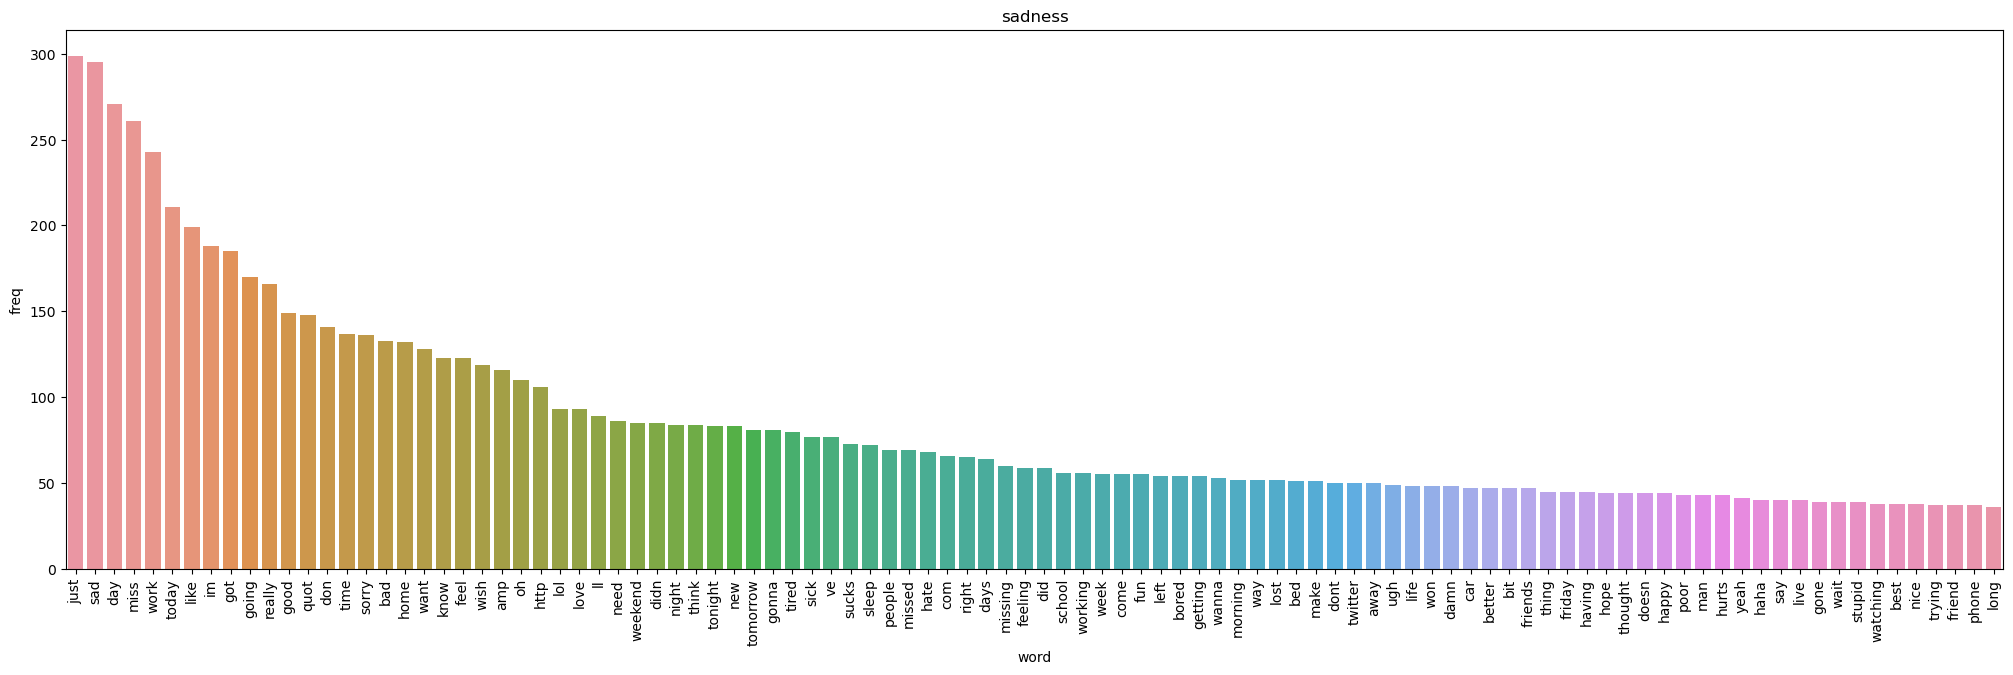

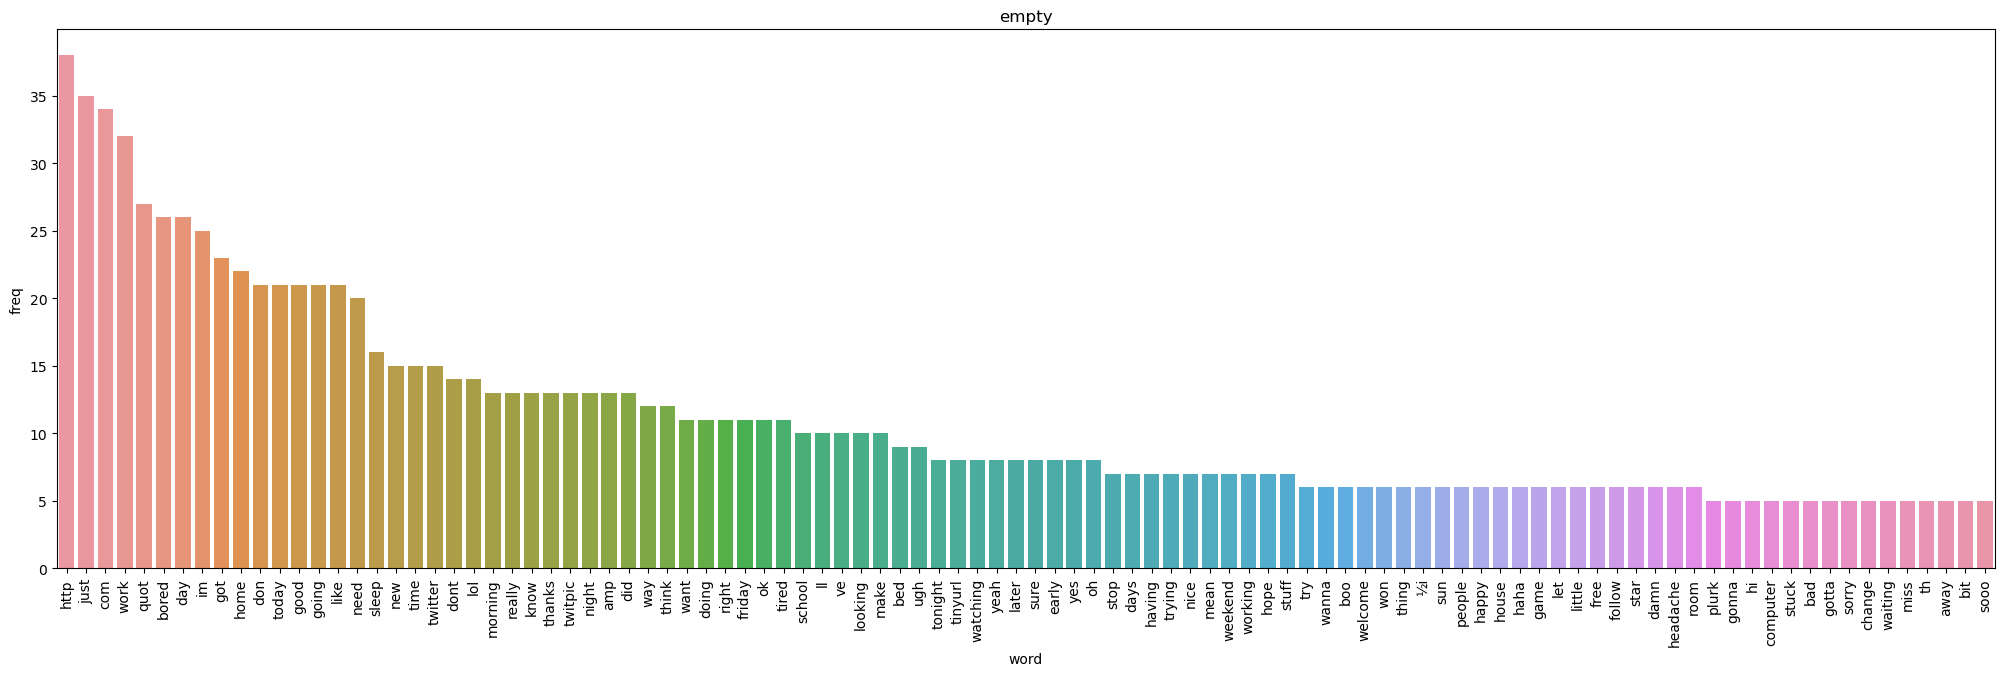

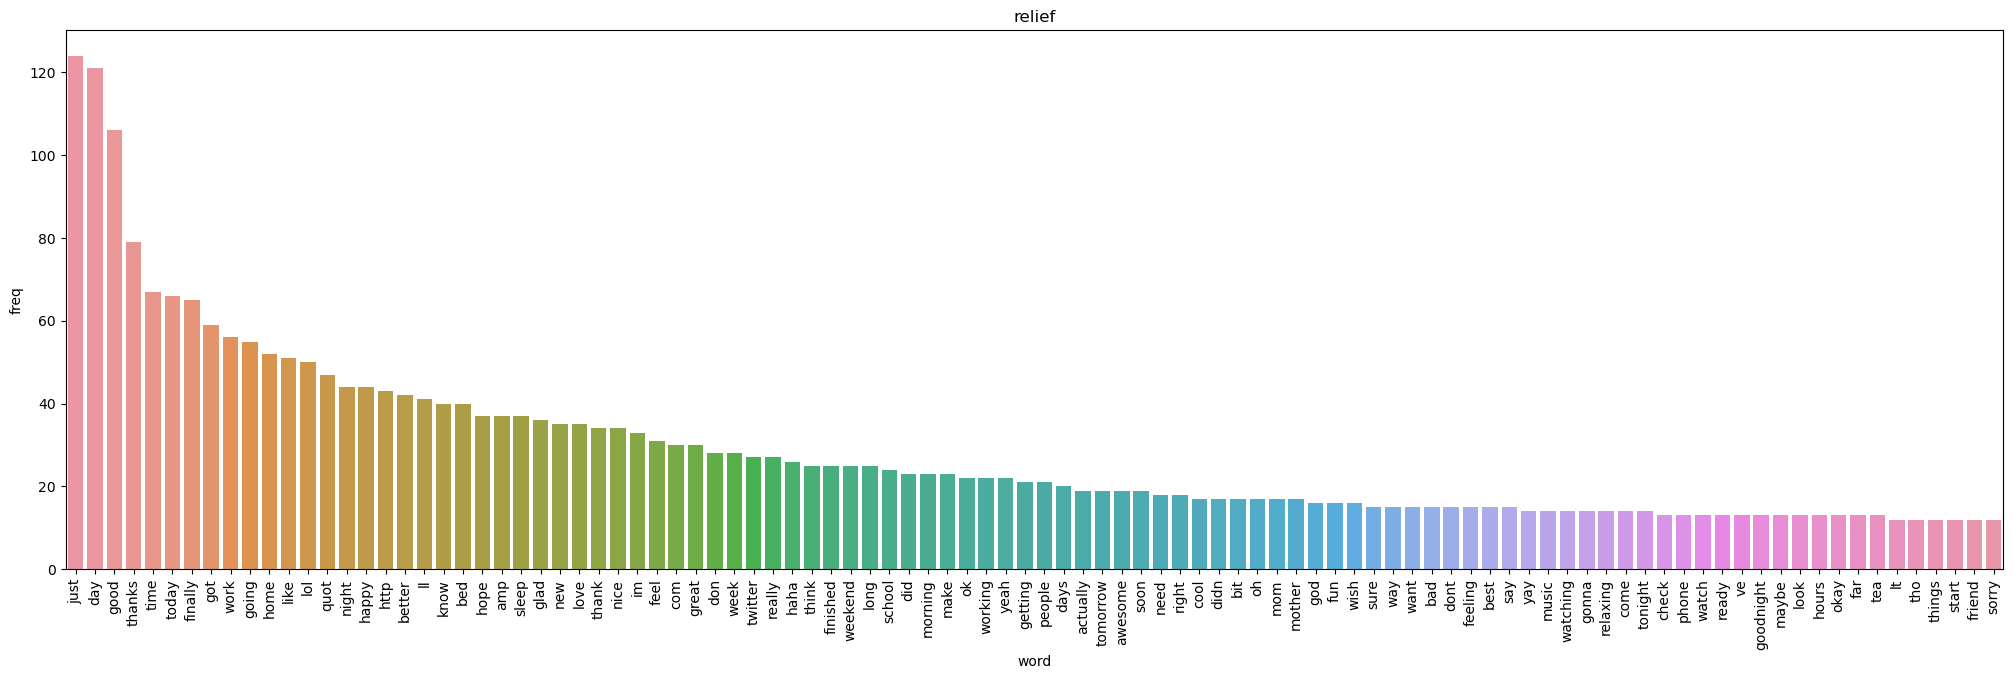

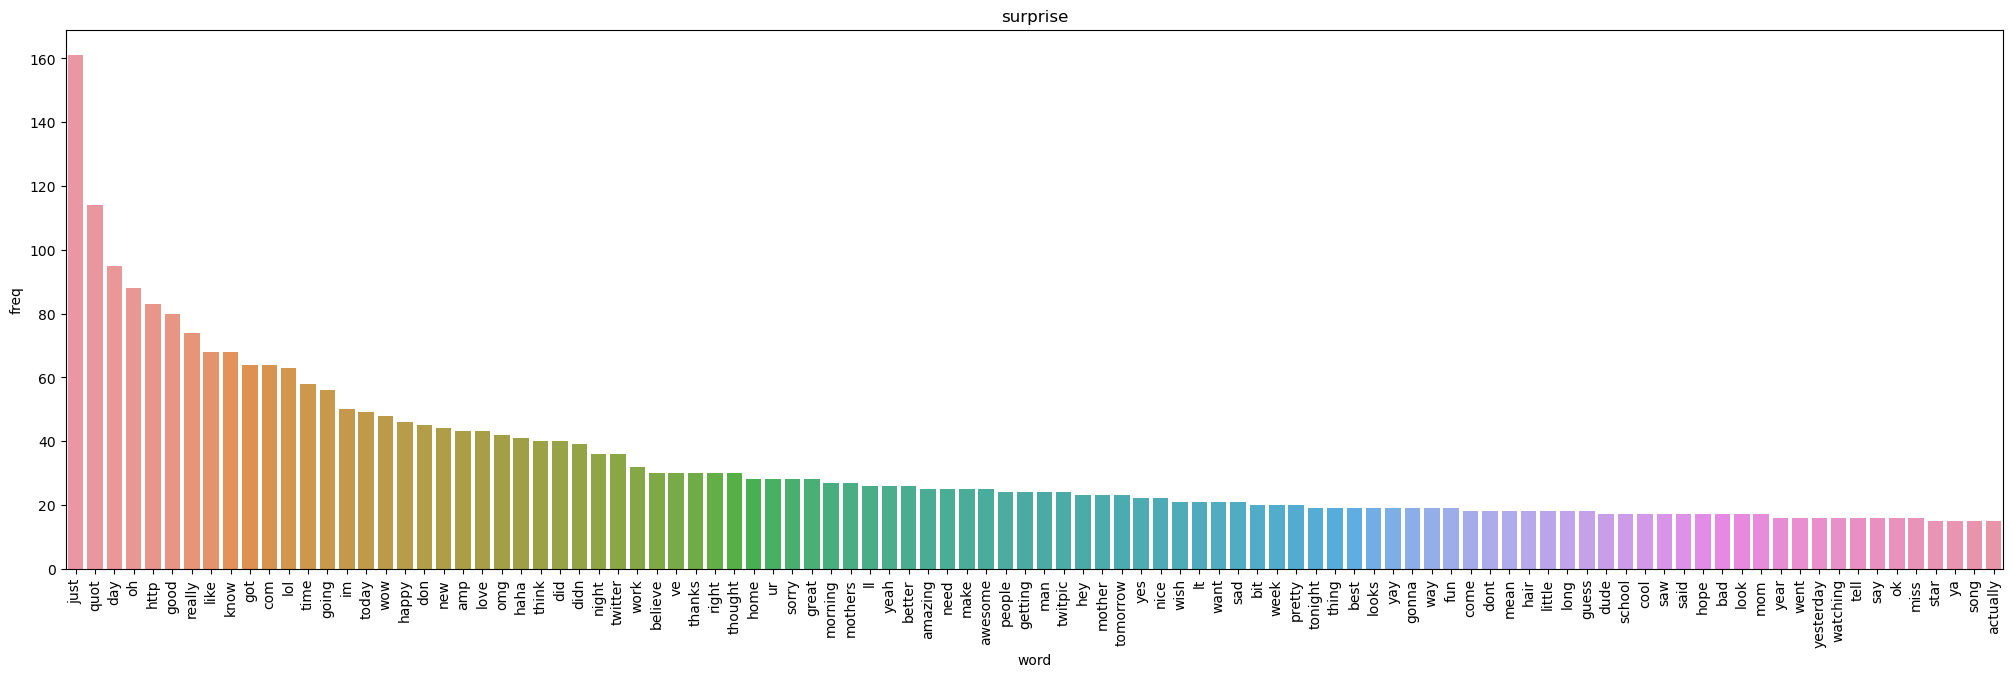

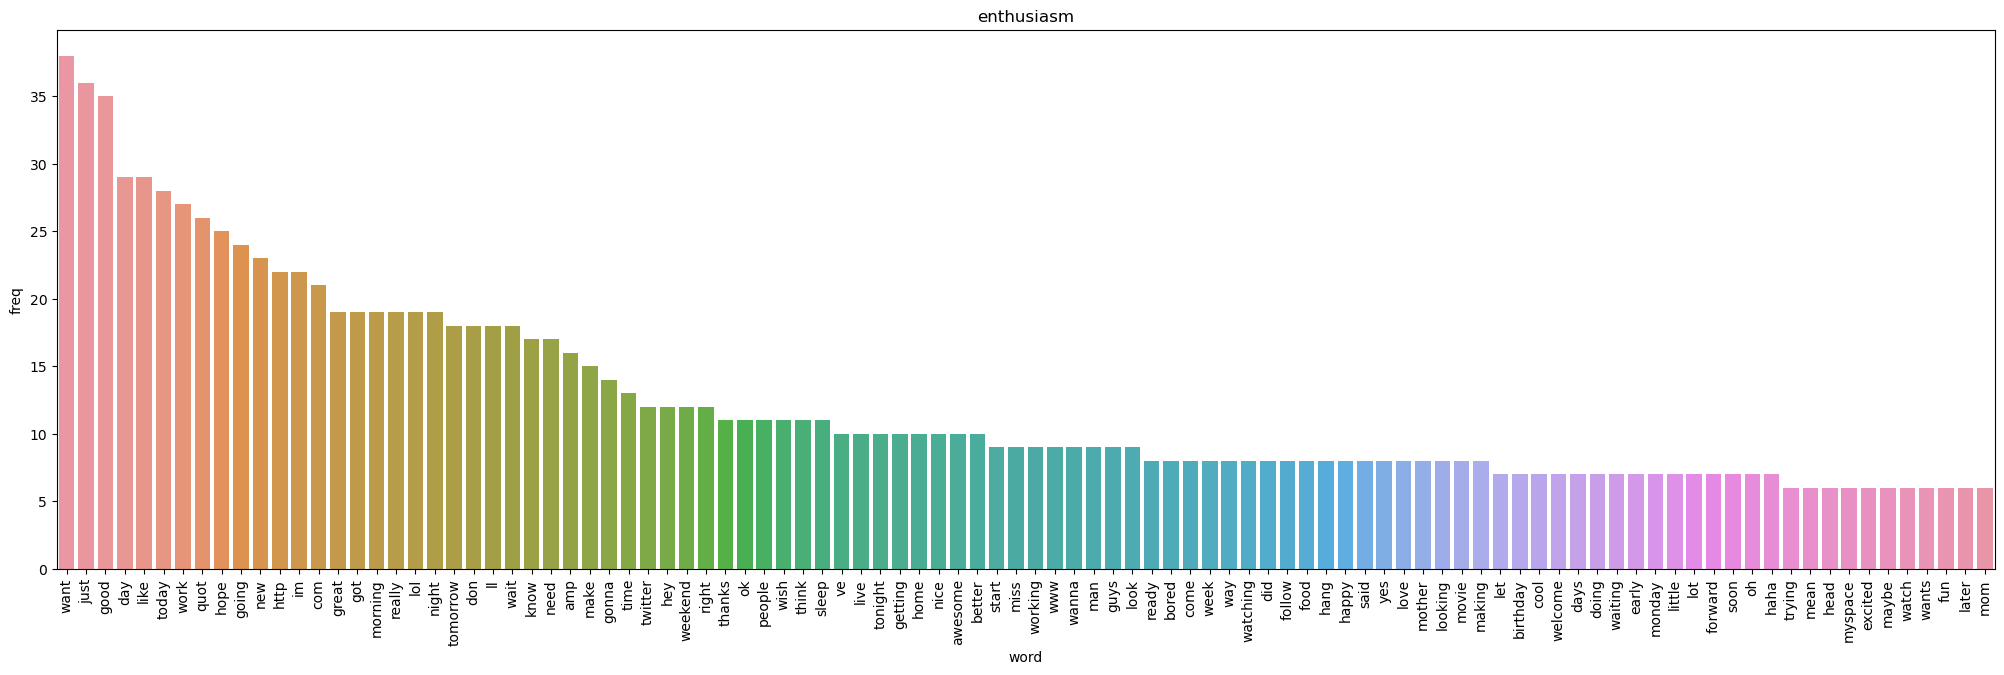

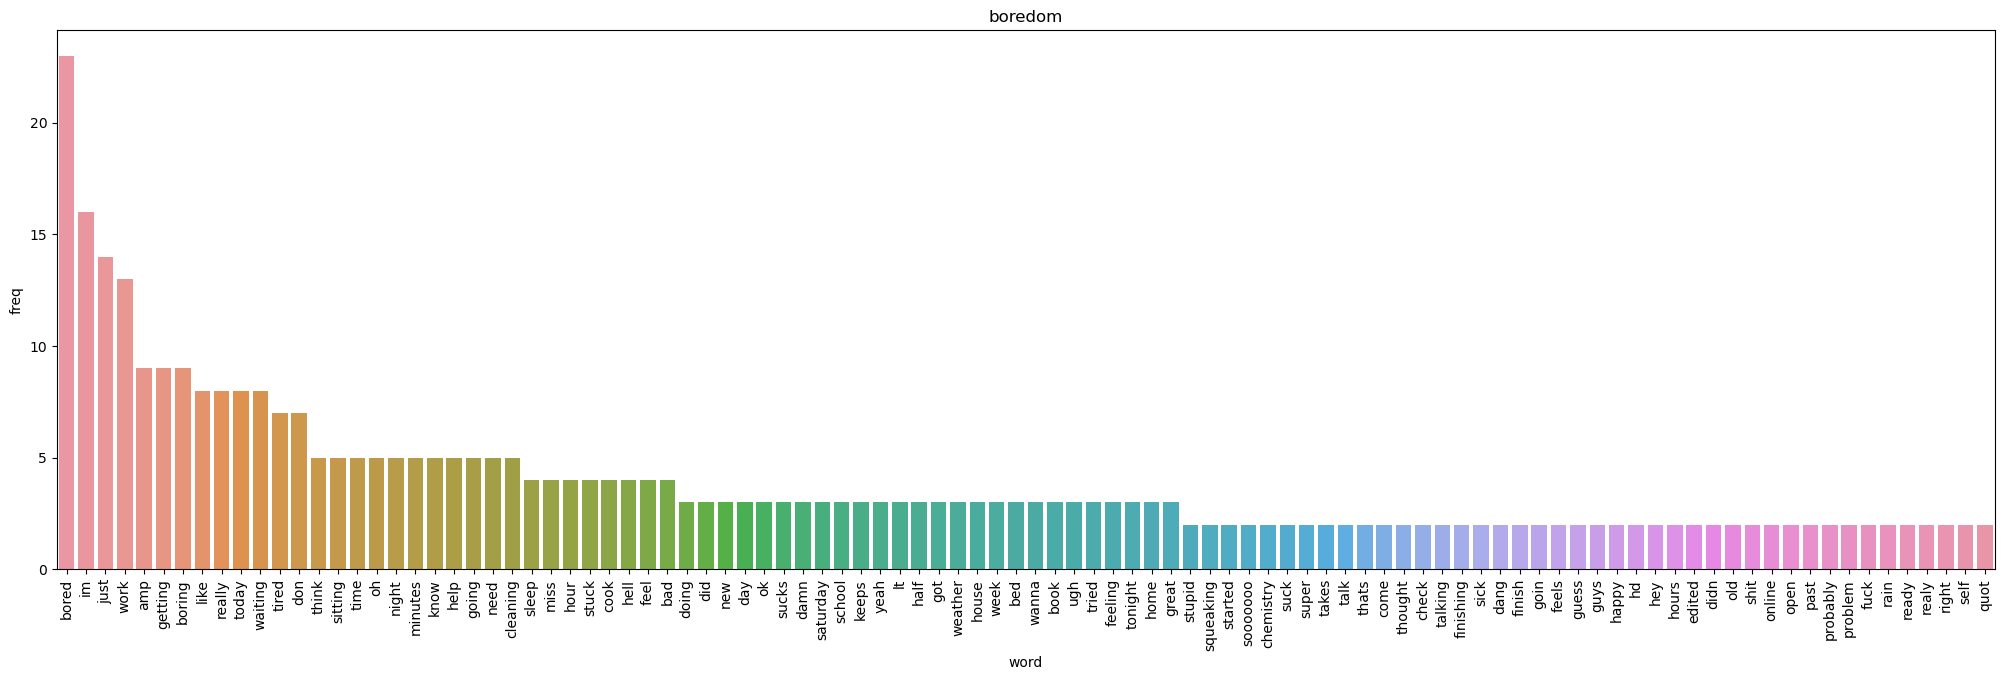

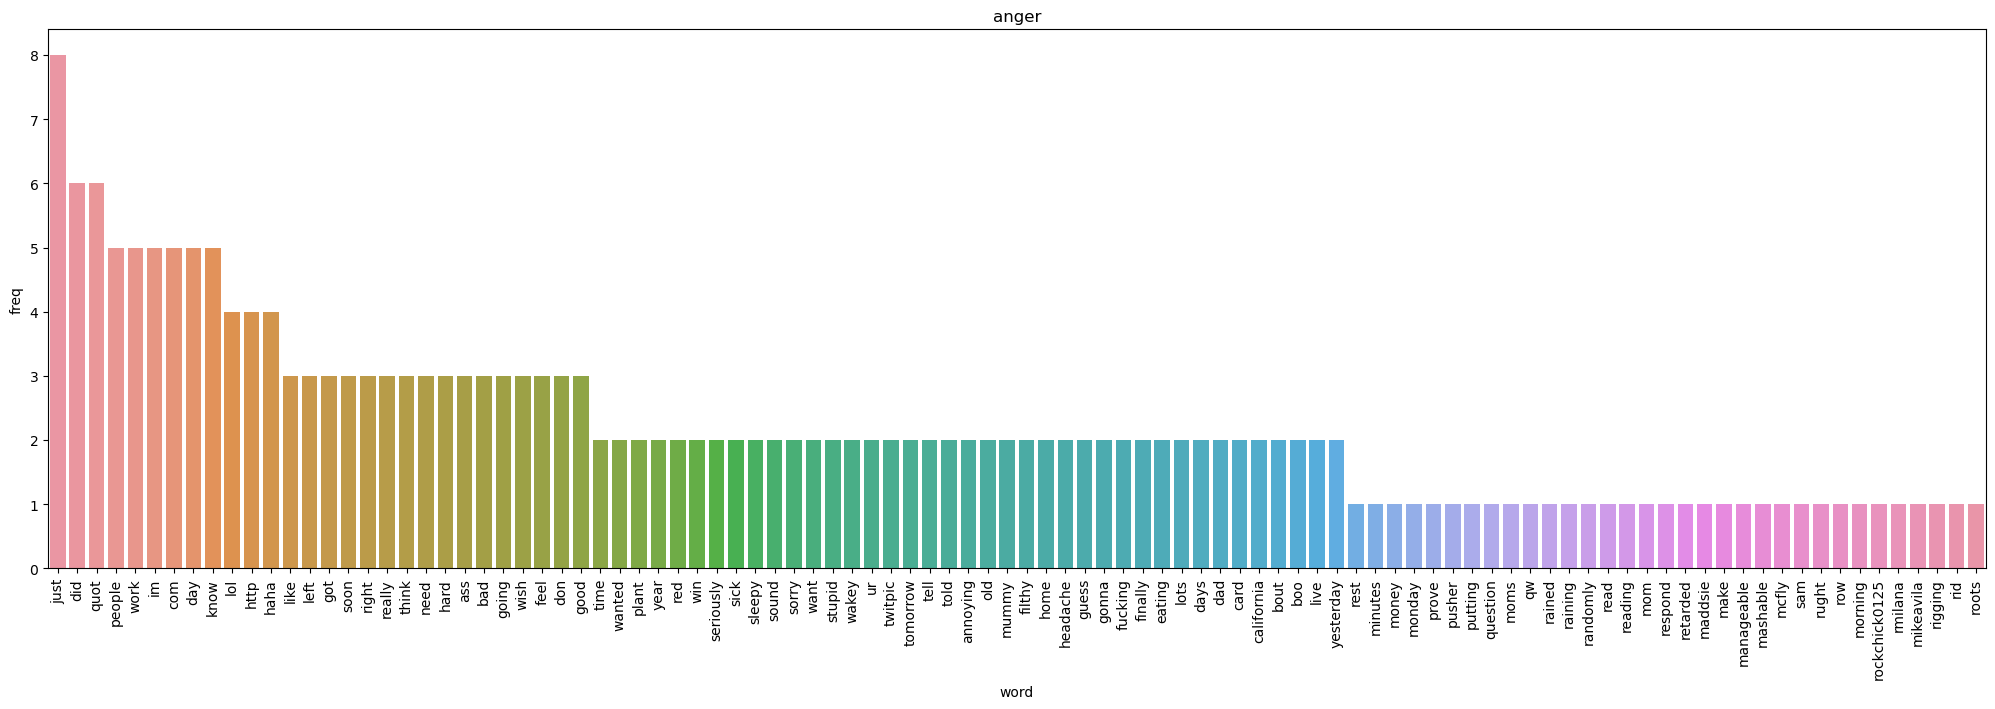

In [8]:
# Frecuecia por sentimientos de las palabras ordenadas de mayor a menor. 
for sentimiento_ in df['sentiment'].unique(): 
    fx.vectorize_sentiment(df, sentimiento = sentimiento_, plot = True)

<AxesSubplot:>

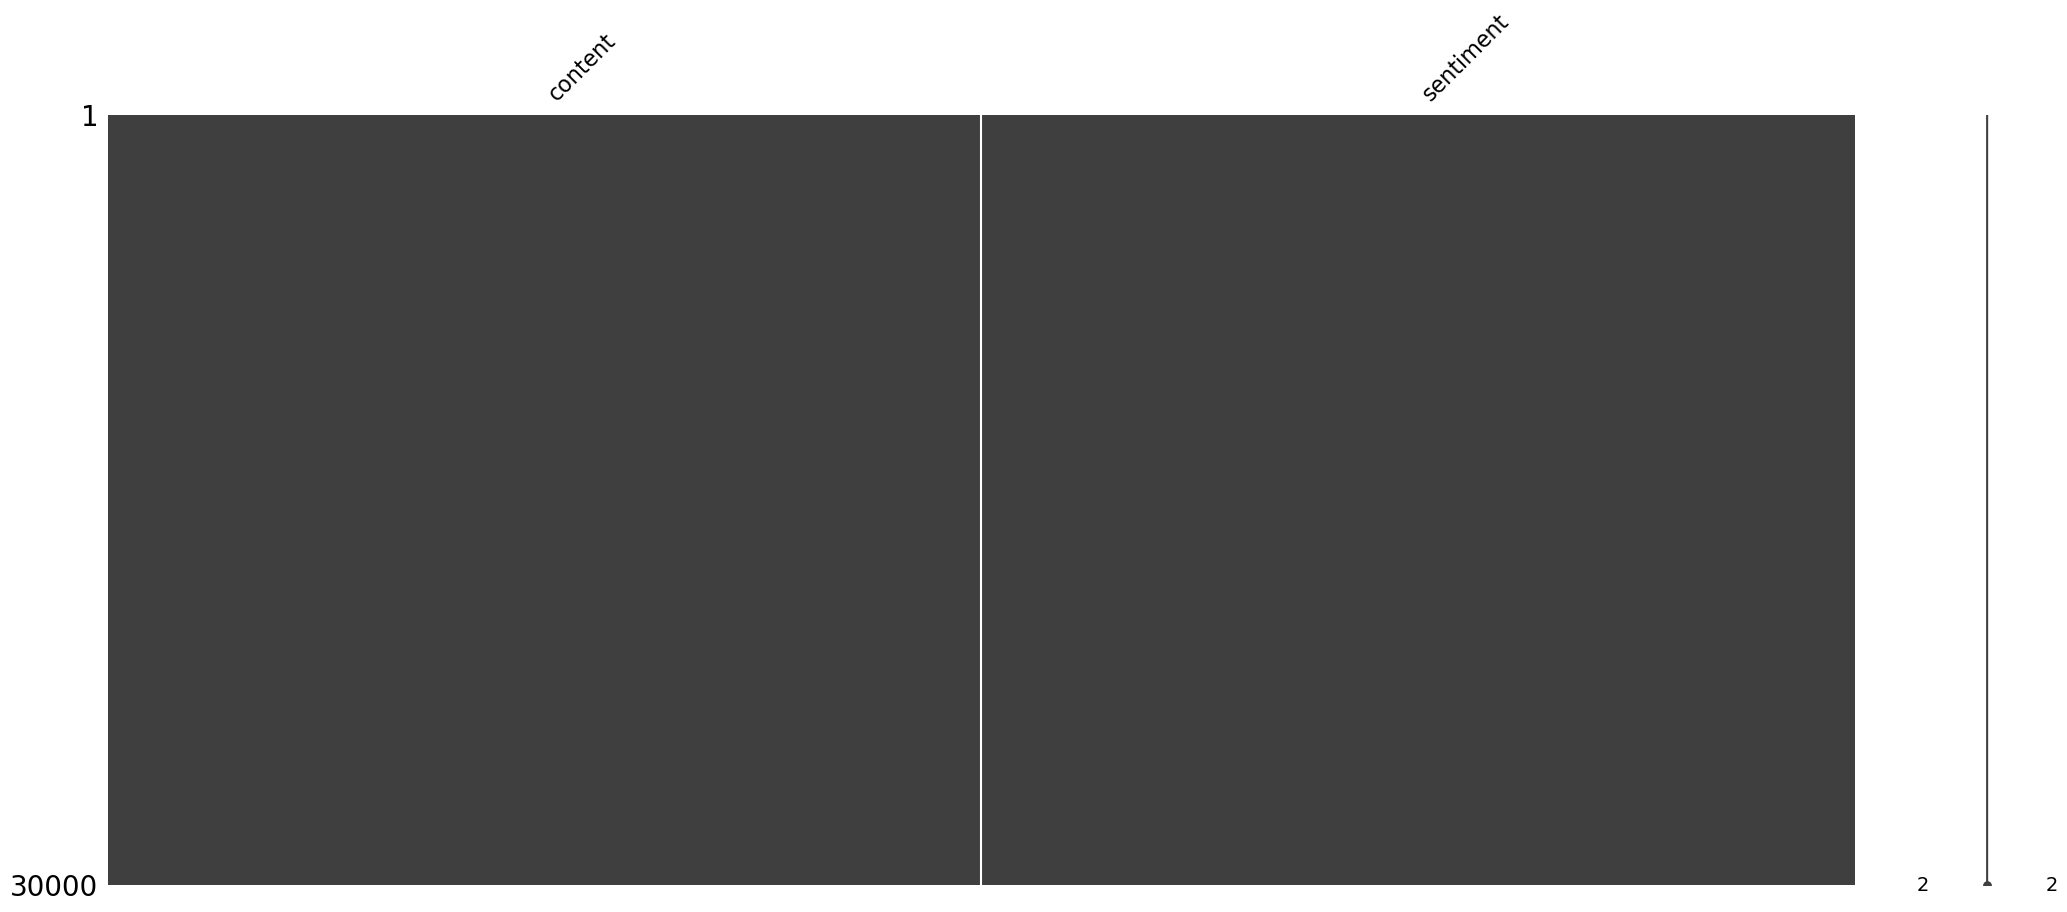

In [9]:
msngo.matrix(df)

El dataset no presenta datos perdidos.

A continuación se implementan las recodificaciones al corpus o contenido del tweet.

In [10]:
fx.clean_text(df, 'content', 'content_clean')

,content,sentiment,content_clean
0,Happy Mama's day to all mothers,love,happy mamas day to all mothers
1,@LysdelTellez I am lost. Please help me find a...,worry,i am lost. please help me find a good home.
2,"@BoomKatt yes yes I AM, networking whore to th...",happiness,yes yes i am networking whore to the fullest....
3,you@snapplynn Wish that would have been your t...,neutral,you wish that would have been your tweet after...
4,now i am doing the MicroEconomics project iha...,worry,now i am doing the microeconomics project iha...
...,...,...,...
29995,I do not want to work tomorrow!,sadness,i do not want to work tomorrow
29996,@KandyBee we shuld do a dance like that its s...,fun,we shuld do a dance like that its seriously ...
29997,"Photo: Got my prints a few days ago, ready for...",happiness,photo got my prints a few days ago ready for t...
29998,@tove_liden Thanks for the follow Tove!,fun,liden thanks for the follow tove


In [11]:
fx.nlp_cleaning(df)

,content,sentiment,content_clean,content_norm,content_norm_stop,content_token,content_token_lemma
0,Happy Mama's day to all mothers,love,happy mama day to all mother,happy mamas day to all mothers,happy mamas day to all mothers,"[happy, mamas, day, to, all, mothers]","[happy, mama, day, to, all, mother]"
1,@LysdelTellez I am lost. Please help me find a...,worry,i am lost please help me find a good home,i am lost. please help me find a good home.,i am lost. please help me find a good home.,"[i, am, lost, ., please, help, me, find, a, go...","[i, am, lost, ., please, help, me, find, a, go..."
2,"@BoomKatt yes yes I AM, networking whore to th...",happiness,yes yes i am networking whore to the fullest ....,yes yes i am networking whore to the fullest....,yes yes i am networking whore to the fullest.....,"[yes, yes, i, am, networking, whore, to, the, ...","[yes, yes, i, am, networking, whore, to, the, ..."
3,you@snapplynn Wish that would have been your t...,neutral,you wish that would have been your tweet after...,you wish that would have been your tweet after...,you wish that would have been your tweet after...,"[you, wish, that, would, have, been, your, twe...","[you, wish, that, would, have, been, your, twe..."
4,now i am doing the MicroEconomics project iha...,worry,now i am doing the microeconomics project ihat...,now i am doing the microeconomics project iha...,now i am doing the microeconomics project ihat...,"[now, i, am, doing, the, microeconomics, proje...","[now, i, am, doing, the, microeconomics, proje..."
...,...,...,...,...,...,...,...
29995,I do not want to work tomorrow!,sadness,i do not want to work tomorrow,i do not want to work tomorrow,i do not want to work tomorrow,"[i, do, not, want, to, work, tomorrow]","[i, do, not, want, to, work, tomorrow]"
29996,@KandyBee we shuld do a dance like that its s...,fun,we shuld do a dance like that it seriously the...,we shuld do a dance like that its seriously ...,we shuld do a dance like that its seriously th...,"[we, shuld, do, a, dance, like, that, its, ser...","[we, shuld, do, a, dance, like, that, it, seri..."
29997,"Photo: Got my prints a few days ago, ready for...",happiness,photo got my print a few day ago ready for the...,photo got my prints a few days ago ready for t...,photo got my prints a few days ago ready for t...,"[photo, got, my, prints, a, few, days, ago, re...","[photo, got, my, print, a, few, day, ago, read..."
29998,@tove_liden Thanks for the follow Tove!,fun,liden thanks for the follow tove,liden thanks for the follow tove,liden thanks for the follow tove,"[liden, thanks, for, the, follow, tove]","[liden, thanks, for, the, follow, tove]"


In [12]:
vect = CountVectorizer()
vect_fit = vect.fit_transform(df['content_clean'])

In [13]:
words = vect.get_feature_names()
words_freq = vect_fit.toarray().sum(axis = 0)

In [14]:
df_words = pd.DataFrame(zip(words, words_freq), columns = ['words', 'words_freq'])

df_words.sort_values(by = ['words_freq'], ascending = False)

,words,words_freq
23588,to,10741
23204,the,9713
11967,it,6598
15593,my,6005
786,and,5627
...,...,...
10952,hostel,1
10948,hospitol,1
10946,hospice,1
10943,hosanna,1


Se establece la recodificación solicitada del vector objetivo, en la cual los sentimientos neutrales, seran reemplazados de forma aleatoria entre Positiva y Negativa.

In [15]:
df['sentiment_code'] = df['sentiment'].replace(['worry'  , 'happiness'  , 'sadness'  , 'love'  , 'surprise'  , 'fun'  , 'relief'  , 'hate'  , 'empty'  , 'enthusiasm'  , 'boredom'  , 'anger'], 
                                    ['Negativa' , 'Positiva' , 'Negativa' , 'Positiva' , 'Positiva' , 'Positiva' , 'Positiva' , 'Negativa' , 'Negativa' , 'Positiva' , 'Negativa' , 'Negativa'])

In [16]:
sentimientos = ['Positiva', 'Negativa']
df['sentiment_code'] = [i.replace('neutral', np.random.choice(sentimientos, 1, p = [0.51, 0.49])[0]) for i in df['sentiment_code']]

In [17]:
df.sample(5, random_state = 15820)

,content,sentiment,content_clean,content_norm,content_norm_stop,content_token,content_token_lemma,sentiment_code
17932,@patrickmanning Yes PM PM you are right,happiness,yes pm pm you are right,yes pm pm you are right,yes pm pm you are right,"[yes, pm, pm, you, are, right]","[yes, pm, pm, you, are, right]",Positiva
8768,@Jae878 aha thanks Jae,happiness,aha thanks jae,aha thanks jae,aha thanks jae,"[aha, thanks, jae]","[aha, thanks, jae]",Positiva
14419,"This is my favourite shirt, because its true. ...",neutral,this is my favourite shirt because it true lt ...,this is my favourite shirt because its true. ...,this is my favourite shirt because its true. l...,"[this, is, my, favourite, shirt, because, its,...","[this, is, my, favourite, shirt, because, it, ...",Positiva
18237,@taylorswift13 ....... i'm wondering if you're...,worry,....... im wondering if youre a awake a i am,....... im wondering if youre as awake as i am.,....... im wondering if youre as awake as i am.,"[......., im, wondering, if, youre, as, awake,...","[......., im, wondering, if, youre, a, awake, ...",Negativa
15206,"@taylor_d No, it's not...",neutral,d no it not ...,d no its not...,d no its not...,"[d, no, its, not, ...]","[d, no, it, not, ...]",Negativa


In [18]:
# Distribucion del vector objetivo recodificado
df['sentiment_code'].value_counts()

Negativa    15150
Positiva    14850
Name: sentiment_code, dtype: int64

<AxesSubplot:xlabel='sentiment_code', ylabel='count'>

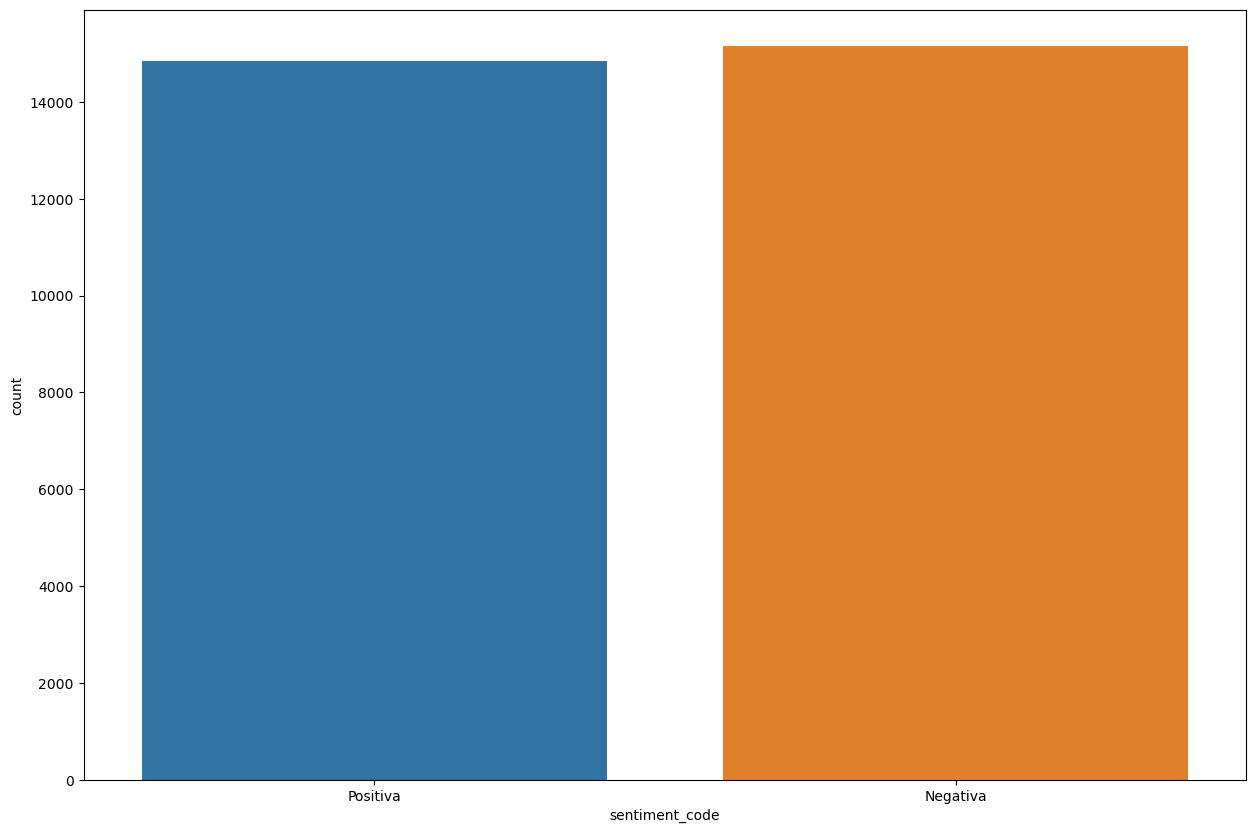

In [19]:
sns.countplot(x = df['sentiment_code'])

In [20]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['content_clean'])
y = df['sentiment_code']

In [21]:
# División de dstos de entrenamiento y validación.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 15820)

In [22]:
print(f'''Datos de entrenamiento X_train_std: {X_train.shape[0]} registros en {X_train.shape[1]} columnas
Datos de validación X_test_std {X_test.shape[0]} registros en {X_test.shape[1]} columnas''') 

Datos de entrenamiento X_train_std: 20100 registros en 26571 columnas
Datos de validación X_test_std 9900 registros en 26571 columnas


Acontinuacion se proponen modelos con una grilla de hiperparametros tentativa

 - MultinomialNB() params = {'alpha': np.linspace(0,20,20)[1:],'class_prior':[None,2,5,10]}
 - RandomForestClassifier() params = {'max_depth':[None, 10, 50, 70], 'n_estimators':[50, 100, 150, 200, 250, 500]}
  - DecisionTreeClassifier() params = {'max_depth':[None, 10, 50, 70], 'min_samples_split':[50, 100, 150, 200, 250, 500], 'ccp_alpha':[10, 20, 30, 40, 50]}
 - LinearSVC() params = {'tol' : [1e-4, 1e-5, 1e-6], 'loss' : ['squared_hinge', 'hinge'], 'max_iter':[50, 100, 150]}
 - LogisticRegression() params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty': ['l1', 'l2']}

Busqueda de hiperparametros he impresion de resultados y entrenamiento de los modelos en base a los mejores hiperparametros.

In [23]:
%%time
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
mnnb_best_param_grid = {'alpha': np.linspace(0,20,20)[1:],'class_prior':[None,2,5,10]}
clf_nb = GridSearchCV(MultinomialNB(),mnnb_best_param_grid, cv = 2, n_jobs = -1).fit(X_train_tfidf, y_train)
y_hat_mnnb_best= clf_nb.predict(X_test)

CPU times: user 621 ms, sys: 167 ms, total: 788 ms
Wall time: 5.79 s


In [24]:
print(f'''Resultados de grilla para metricas e hiperparametros
Resultados MultinomialNB
Mejor parametro: {clf_nb.best_params_}
Mejor score: {clf_nb.best_score_}
{classification_report(y_hat_mnnb_best, y_test)}''')

Resultados de grilla para metricas e hiperparametros
Resultados MultinomialNB
Mejor parametro: {'alpha': 5.263157894736842, 'class_prior': None}
Mejor score: 0.668955223880597
              precision    recall  f1-score   support

    Negativa       0.78      0.66      0.71      5891
    Positiva       0.59      0.72      0.65      4009

    accuracy                           0.69      9900
   macro avg       0.68      0.69      0.68      9900
weighted avg       0.70      0.69      0.69      9900



In [25]:
%%time
rf_param_grid = {'max_depth':[None, 10, 50, 70], 'n_estimators':[50, 100, 150, 200, 250, 500]}
clf_rf = GridSearchCV(RandomForestClassifier(random_state = 158),rf_param_grid, cv = 2, n_jobs = -1).fit(X_train, y_train)
y_hat_rf_best= clf_rf.predict(X_test)

CPU times: user 1min 9s, sys: 643 ms, total: 1min 10s
Wall time: 8min 17s


In [26]:
print(f'''Resultados de grilla para metricas e hiperparametros
Resultados RandomForestClassifier
Mejor parametro: {clf_rf.best_params_}
Mejor score: {clf_rf.best_score_}
{classification_report(y_hat_rf_best, y_test)}''')

Resultados de grilla para metricas e hiperparametros
Resultados RandomForestClassifier
Mejor parametro: {'max_depth': 70, 'n_estimators': 250}
Mejor score: 0.6735820895522389
              precision    recall  f1-score   support

    Negativa       0.71      0.68      0.70      5265
    Positiva       0.66      0.69      0.67      4635

    accuracy                           0.68      9900
   macro avg       0.68      0.69      0.68      9900
weighted avg       0.69      0.68      0.69      9900



In [37]:
%%time
dt_best_param_grid = {'max_depth':[None, 10, 50, 70], 'min_samples_split':[50, 100, 150, 200, 250, 500], 'ccp_alpha':[10, 20, 30, 40, 50]}
clf_dt = GridSearchCV(DecisionTreeClassifier(random_state = 158), dt_best_param_grid, cv = 5, n_jobs = -1).fit(X_train, y_train)
y_hat_dt_best = clf_dt.predict(X_test)

CPU times: user 7.17 s, sys: 427 ms, total: 7.6 s
Wall time: 3min 44s


In [38]:
print(f'''Resultados de grilla para metricas e hiperparametros
Resultados DecisionTreeClassifier
Mejor parametro: {clf_dt.best_params_}
Mejor score: {clf_dt.best_score_}
{classification_report(y_hat_dt_best, y_test)}''')

Resultados de grilla para metricas e hiperparametros
Resultados DecisionTreeClassifier
Mejor parametro: {'ccp_alpha': 10, 'max_depth': None, 'min_samples_split': 50}
Mejor score: 0.503681592039801
              precision    recall  f1-score   support

    Negativa       1.00      0.51      0.67      9900
    Positiva       0.00      0.00      0.00         0

    accuracy                           0.51      9900
   macro avg       0.50      0.25      0.34      9900
weighted avg       1.00      0.51      0.67      9900



In [29]:
%%time    
clf_svc_param_grid = {'tol' : [1e-4, 1e-5, 1e-6], 'loss' : ['squared_hinge', 'hinge'], 'max_iter':[50, 100, 150]}
clf_svc = GridSearchCV(LinearSVC(random_state = 158),param_grid = clf_svc_param_grid, cv = 5, n_jobs = -1).fit(X_train, y_train)
y_hat_svc = clf_svc.predict(X_test)

/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225

CPU times: user 945 ms, sys: 97.3 ms, total: 1.04 s
Wall time: 11.9 s


In [30]:
print(f'''Resultados de grilla para metricas e hiperparametros
Resultados LinearSVC
Mejor parametro: {clf_svc.best_params_}
Mejor score: {clf_svc.best_score_}
{classification_report(y_hat_svc, y_test)}''')

Resultados de grilla para metricas e hiperparametros
Resultados LinearSVC
Mejor parametro: {'loss': 'hinge', 'max_iter': 150, 'tol': 0.0001}
Mejor score: 0.6510945273631841
              precision    recall  f1-score   support

    Negativa       0.67      0.67      0.67      5029
    Positiva       0.66      0.66      0.66      4871

    accuracy                           0.66      9900
   macro avg       0.66      0.66      0.66      9900
weighted avg       0.66      0.66      0.66      9900



In [31]:
%%time
lgr_best_param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty': ['l1', 'l2']}
clf_lr = GridSearchCV(LogisticRegression(random_state = 158), lgr_best_param_grid, cv = 5, n_jobs = -1).fit(X_train, y_train)
y_hat_lgr_best = clf_lr.predict(X_test)

/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

CPU times: user 1.53 s, sys: 74.4 ms, total: 1.6 s
Wall time: 5.95 s


In [32]:
print(f'''Resultados de grilla para metricas e hiperparametros
Resultados LogisticRegression
Mejor parametro: {clf_lr.best_params_}
Mejor score: {clf_lr.best_score_}
{classification_report(y_hat_lgr_best, y_test)}''')

Resultados de grilla para metricas e hiperparametros
Resultados LogisticRegression
Mejor parametro: {'C': 0.1, 'penalty': 'l2'}
Mejor score: 0.6766169154228856
              precision    recall  f1-score   support

    Negativa       0.69      0.69      0.69      5037
    Positiva       0.68      0.68      0.68      4863

    accuracy                           0.69      9900
   macro avg       0.69      0.69      0.69      9900
weighted avg       0.69      0.69      0.69      9900



Serialización del mejor modelo e hiperparametros para los 5 clasificadores.

In [33]:
pickle.dump(clf_nb, open('clf_nb_jgh.sav', 'wb'))
pickle.dump(clf_rf, open('clf_rf_jgh.sav', 'wb'))
pickle.dump(clf_dt, open('clf_dt_jgh.sav', 'wb'))
pickle.dump(clf_svc, open('clf_svc_jgh.sav', 'wb'))
pickle.dump(clf_lr, open('clf_lr_jgh.sav', 'wb'))

De acuerdo a las metricas observadas, serialezaremos todos los modelos. Siendo los mejores modelos LogisticRegression() y MultinomialNB(), los cuales alcanzan un 69% de accuracy. El resto de los modelos serializados, estan por sobre el 60% de accuracy, exceptuando DecisionTreeClassifier, el cual tiene las peores metricas con un 51% de accuracy.